In [10]:
import pandas as pd
import tensorflow as tf
from keras import layers, Input, Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [1]:
import keras
print(keras.__version__)

3.7.0


In [4]:
data = pd.read_csv(
    './data/ambient_temperature_system_failure.csv')

# Exclude datetime column
data_values = data.drop('time',
                        axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
                              columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',
                      data['time'])

In [5]:
data_converted = data_converted.dropna()

In [11]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = layers.Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 327.6203
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0016
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 3.6086e-04
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 3.6382e-04
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 3.6122e-04
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 3.5738e-04
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 3.5948e-04
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 3.5893e-04
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 3.6037e-04
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 3.5169e-04
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 3.5707e-04
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 3.4693e-04
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 3.5196e-04
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/ste

In [12]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [13]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


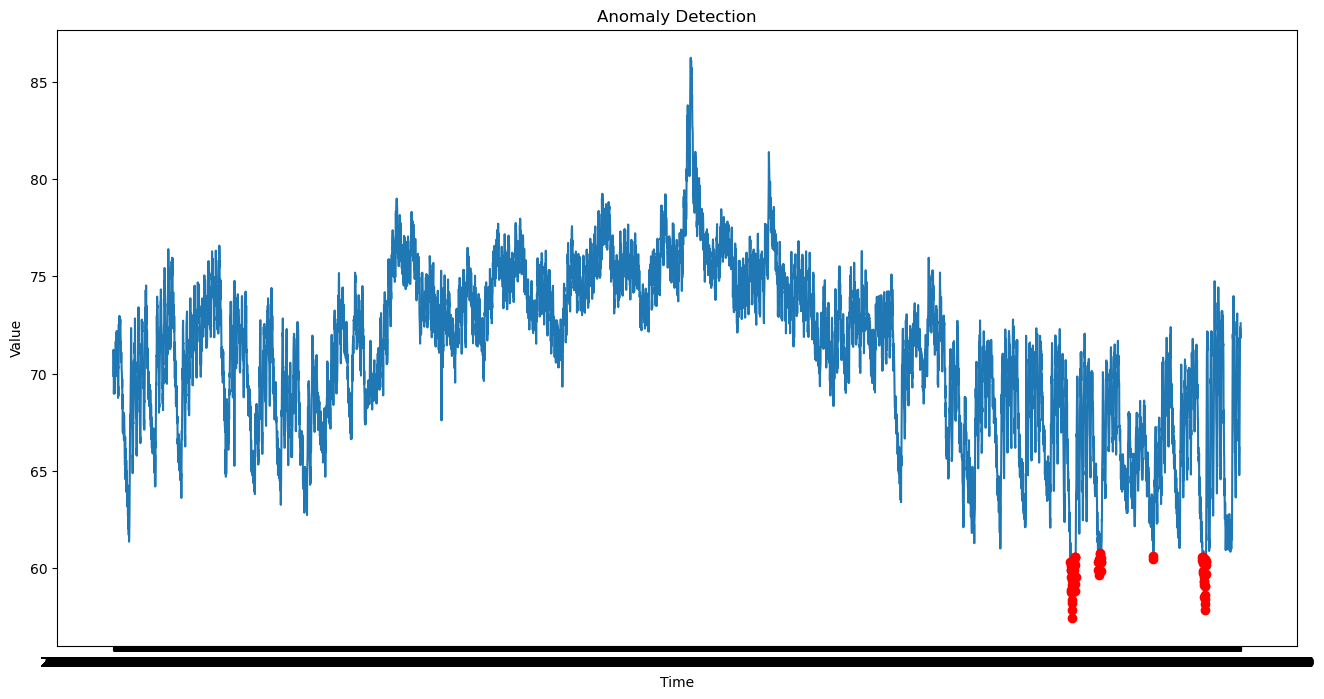

In [14]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
